## BECS 2 Data Challenge: Predicting Cancer Status of Patients
Koch Kilian (ZHAW), Rieder Jonathan (ZHAW), Yar Kevin (ZHAW)

The aim of this project work is to predict 6 different healt status of patients (healthy, breast-, lung-, pancreatic-, colorectal- and prostate cancer). The prediction is based on mass spectroscopy data of different protein levels meassured in patients blood. 

## Part 1: Loading packages and define initial Parameters

In [7]:
#import necessary packages 
import os
import random
import xgboost
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn_genetic import GAFeatureSelectionCV

os.getcwd()
"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

## Part 2: Data Preprocessing
In this section the raw data is preprocessed

In [ ]:
#Kilian insert your code here

## Part 3: Data Preparation
In this section the raw data is prepared and reshaped to be fed into the different models. Furhtermore, the distribution of the input data is visualized to check if the data set is balanced. The data is converted into two main variables X (patiens and the coresponding protein quantities) and y (patients and the coresponding healt condition).


In [2]:
#create pandas dataframe
#load data with protein quantities
path = "rawData/tidy.csv"

#load data for patients healt status
pathMet = "rawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

#remove samples which are not in the metadata index column (quality controle etc)
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]
tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")
tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]
tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

In [3]:
# Give the proteins a ranking by the concentration
tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)

C:\Users\test\AppData\Local\Temp/ipykernel_13508/248670896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)


### Data filtering

#### Due to the high range of protein concentration in the Human blood plasma we need to remove the highest and lowest concentrated proteins.
#### It can also be observed that the highest variation between patients is in the range of 10e3.5 - 10e7

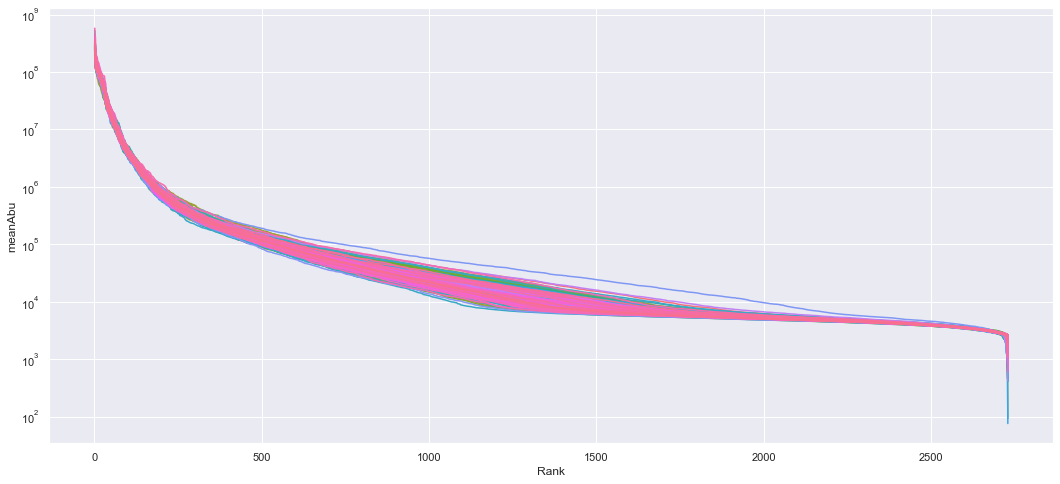

In [16]:
# With all proteins
sns.set(rc={'figure.figsize':(18,8)})
_ = sns.lineplot(x="Rank", y="meanAbu", hue="R.FileName", data=tidySub)
_.set_yscale("log")
_.legend_.remove()


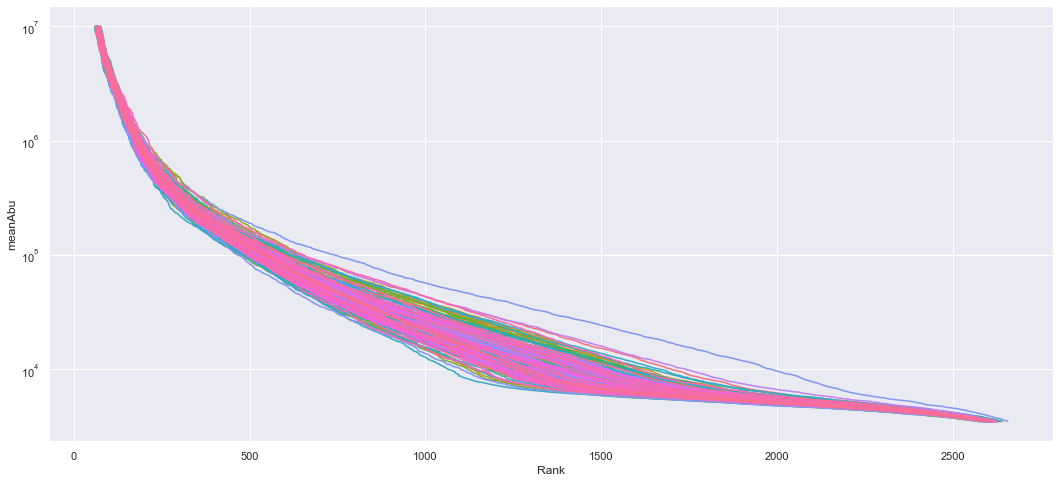

In [23]:
# With proteins in the range

tidySubFiltered = tidySub[ (tidySub.meanAbu <= 10000000) & (tidySub.meanAbu >=3500) ] 

sns.set(rc={'figure.figsize':(18,8)})
_ = sns.lineplot(x="Rank", y="meanAbu", hue="R.FileName", data=tidySubFiltered)
_.set_yscale("log")
_.legend_.remove()


In [25]:
#reshape data for model
#X data
tidyReshaped = tidySubFiltered.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()



uniprot,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y696,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,21067.064453,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,231849.765625,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,43056.816406,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,27962.792969,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,28075.748047,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938


In [30]:
#y condition
Group =  tidySubFiltered.drop(["uniprot", "meanAbu", "Rank"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()
Group.to_clipboard()


In [31]:
#merge X and y and set dataframe to numerical values
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")
data = data.set_index("R.FileName")

In [32]:
X_ = data.iloc[:, :-1].apply(np.log2)
y_ = data.iloc[:,-1]

#check first 10 entries of the dataframe 
data[:10]

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer
J_D201211_MDIA_P705_SExp01-BGSID-105_R01,168020.156250,314351.937500,43850.906250,7771.826172,29071.429688,71324.187500,113709.164062,164368.421875,1.048406e+06,439806.000000,...,68271.148438,3907.875488,5595.822754,5423.373535,6921.024902,64960.882812,5701776.00,14410.666992,218686.546875,Healthy
J_D201211_MDIA_P705_SExp01-BGSID-106_R01,30662.833984,56251.250000,22177.605469,3568.471436,7860.810059,5676.283203,7791.059082,14281.361328,4.652126e+04,86427.093750,...,70641.117188,5911.922852,5732.438477,5113.707031,NaN,14672.596680,2764777.00,NaN,137199.046875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-107_R01,28435.175781,35869.933594,NaN,3502.998779,7316.994629,7915.940430,5812.071777,14288.806641,1.516024e+05,36148.906250,...,103312.960938,5317.896484,3941.360596,4759.937988,3729.927002,15953.640625,2216572.25,4058.714844,154778.015625,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-108_R01,37487.718750,106022.242188,4052.228027,3884.076416,5557.278809,15570.591797,9720.247070,38907.343750,1.918306e+05,46801.824219,...,104351.617188,6847.056641,3552.546631,NaN,NaN,22813.226562,2690729.00,3660.502686,101316.054688,Colorectal Cancer


{'whiskers': [<matplotlib.lines.Line2D at 0x2c913df3850>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x2c913df3eb0>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x2c9190507c0>,
  ...],
 'medians': [<matplotlib.lines.Line2D at 0x2c90fd852b0>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x2c90fd855e0>,
  ...],
 'means': []}

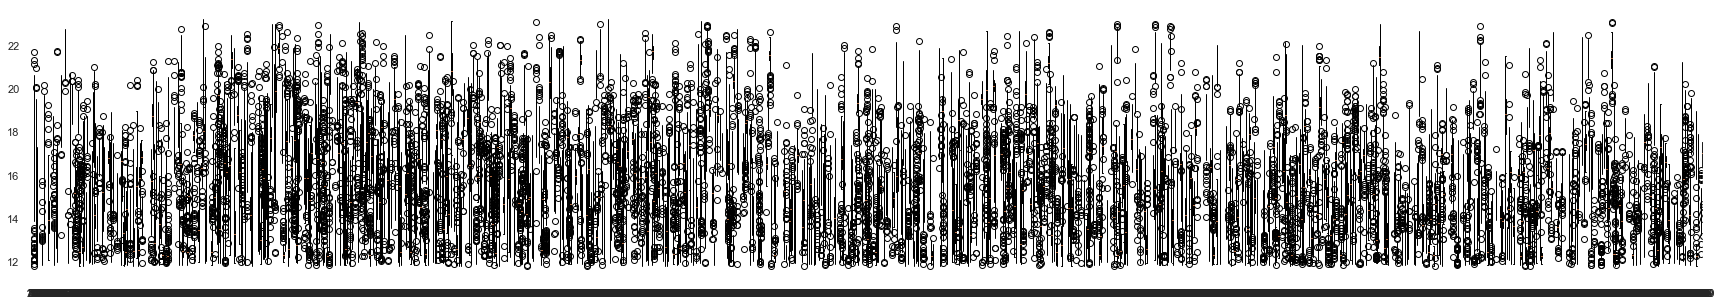

In [33]:
fig, ax = plt.subplots(1,1, figsize=(30, 5))

ax.boxplot(X_)

### Part 4: Creation of Data Sets, Feature and Model Selection
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [34]:
#Make pipeline
dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X_)

In [37]:
# Encode target labels
labEnc = preprocessing.LabelEncoder() 
y = labEnc.fit_transform(y_) 
cancerDict = dict(set(zip(y, y_)))
cancerTypes = list(cancerDict.items())
cancerTypes.sort()
cancerTypes


[(0, 'Breast Cancer'),
 (1, 'Colorectal Cancer'),
 (2, 'Healthy'),
 (3, 'Lung Cancer'),
 (4, 'Pancreatic Cancer'),
 (5, 'Prostate Cancer')]

In [43]:
# Save X and y for next session
joblib.dump(y, "Models2/y.pkl")
joblib.dump(X, "Models2/X.pkl")


['Models2/X.pkl']

In [8]:
# load saved X and y 
y = joblib.load("Models2/y.pkl")
X = joblib.load("Models2/X.pkl")


## Feature selection

### Two possibilities:
* Tree-based feature selection - sklearn.feature_selection.SelectFromModel
    * May be used with sklearn.tree models
##
* Genetic algorithm feature selection - sklearn_genetic.GAFeatureSelection
    * May be used with xgboost

### Random Forest 
#### with **sklearn.feature_selection.SelectFromModel**

Original X shape: (181, 2700)
Feature selected X_new shape: (181, 90)


['Models2/featSel_RF.pkl']

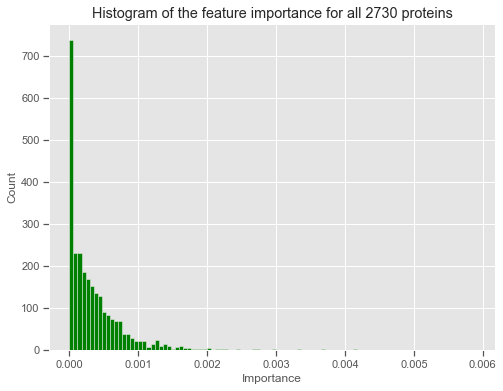

In [65]:
# Tree Feature Selection 

"""
Can be used in pipeline
clf = Pipeline([ 
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
#create Random Forest classifier with random hyperparameters
#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}
params = {}
clf_RA  = RandomForestClassifier(random_state=0, **params)
clf_RA.fit(X, y)

#checkout importance in a histogram
plt.figure(figsize=(8,6))
plt.hist(clf_RA.feature_importances_, bins=100, color='green')
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")


#get the reduced X
selector  = SelectFromModel(estimator = clf_RA, prefit=True, max_features=90)
X_RF      = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_RF.shape}")

joblib.dump(X_RF, "Models2/X_RF.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_RF.pkl")


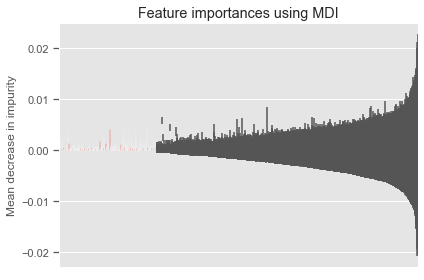

In [10]:
# Visualize feature importance

importances = clf_RA.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_RA.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()


### Random Forest 
#### with **sklearn_genetic.GAFeatureSelection**

In [46]:
#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}
params  = {}
clf_RF    = RandomForestClassifier(random_state=0, **params)

evolved_estimator = GAFeatureSelectionCV(
    estimator   = clf_RF,
    cv          = None,
    population_size=20, 
    generations =40,
    crossover_probability=0.8,
    mutation_probability = 0.15,
    n_jobs      = -1,
    scoring     = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

# Features selected by the algorithm
X_RFGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_RFGA, "Models2/X_RFGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_RFGA.pkl")


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.499272	0.0334821  	0.541441   	0.431532   
1  	38    	0.529707	0.023863   	0.596246   	0.491441   
2  	39    	0.536134	0.0153825  	0.574625   	0.508408   
3  	38    	0.546141	0.0122411  	0.574625   	0.53018    
4  	39    	0.555015	0.0137623  	0.574625   	0.535435   
5  	39    	0.56018 	0.0104874  	0.574174   	0.535886   
6  	38    	0.559602	0.0146822  	0.574174   	0.519369   
7  	38    	0.564925	0.0167939  	0.591291   	0.524625   
8  	39    	0.562125	0.0112338  	0.574174   	0.53003    
9  	39    	0.562928	0.0121911  	0.57973    	0.536336   
10 	39    	0.560653	0.014437   	0.57973    	0.524324   
11 	39    	0.569474	0.0131663  	0.607808   	0.546547   
12 	40    	0.564917	0.0220253  	0.607808   	0.502252   
13 	39    	0.576239	0.0156012  	0.607808   	0.541441   
14 	37    	0.577365	0.0162377  	0.607808   	0.541592   
15 	38    	0.577958	0.0137492  	0.607808   	0.552402   
16 	38    	0.582665	0.0147213  	0.607808   	0.54

['Models2/featSel_RFGA.pkl']

### XGboost 
#### with **sklearn.feature_selection.SelectFromModel**

Original X shape: (181, 2700)
Feature selected X_new shape: (181, 90)


['Models2/featSel_XG.pkl']

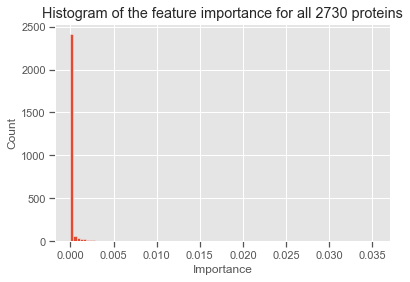

In [109]:

params = dict(tree_method="exact", 
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XG = xgboost.XGBClassifier(random_state=0, **params)
clf_XG.fit(X,y)

#checkout importance in a histogram
plt.hist(clf_XG.feature_importances_, bins=100)
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

selector = SelectFromModel(estimator = clf_XG, max_features=90)
selector.fit(X,y)

X_XG = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_XG.shape}")

joblib.dump(X_XG, "Models2/X_XG.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_XG.pkl")

In [56]:
"""import seaborn as sns 

sns.set_theme(style="ticks")

sns.pairplot(X_[:,selector.get_support()] )
"""

TypeError: '(slice(None, None, None), array([ True,  True, False, False, False]))' is an invalid key

### XGboost 
#### with **sklearn_genetic.GAFeatureSelection**

In [57]:
params = dict(tree_method="exact", 
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XG = xgboost.XGBClassifier(random_state=0, **params)
clf_XG.fit(X,y)

evolved_estimator = GAFeatureSelectionCV(
    estimator           = clf_XG,
    cv                  = None,
    population_size     =25, 
    generations         =40,
    crossover_probability=0.8,
    mutation_probability= 0.1,
    n_jobs              = -1,
    scoring             = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

#susbet data to only the chosen features
X_XGGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_XGGA, "Models2/X_XGGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_XGGA.pkl")


KeyboardInterrupt: 

## Part 5: Model Training

In [111]:
"""
The different features from part 4 are loaded here to find the optimal set of features for the prediction
"""
featSel_RF = joblib.load("Models2/featSel_RF.pkl")
featSel_RFGA = joblib.load("Models2/featSel_RFGA.pkl")   
featSel_XG = joblib.load("Models2/featSel_XG.pkl")       #<-- WINNER for Xgboost very high for random forest
#featSel_XGGA = joblib.load("Models2/featSel_XGGA.pkl")

#cancerTypes = joblib.load("rawData/cancerTypes.pkl")

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X[:,featSel_XG], y, test_size=0.3, random_state=0)

### Random Forest

In [113]:
clf_RF      = RandomForestClassifier(random_state=0)
clf_RF.fit(X_train ,y_train)
y_RFpred    = clf_RF.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred, target_names=cancerTypes))

Accuracy Random Forest: 0.7272727272727273
                   precision    recall  f1-score   support

    Breast Cancer       0.55      0.67      0.60         9
Colorectal Cancer       0.75      0.82      0.78        11
          Healthy       0.88      0.78      0.82         9
      Lung Cancer       0.60      0.50      0.55         6
Pancreatic Cancer       0.80      0.80      0.80        10
  Prostate Cancer       0.78      0.70      0.74        10

         accuracy                           0.73        55
        macro avg       0.72      0.71      0.71        55
     weighted avg       0.73      0.73      0.73        55



### XGBoost Classifier

In [114]:
#define some parameters for xgboost to avoid warnings
params = dict(tree_method="exact", 
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XG = xgboost.XGBClassifier(random_state=0, **params)

clf_XG.fit(X_train ,y_train)
y_XGpred = clf_XG.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGpred))
print(classification_report(y_test, y_XGpred, target_names=cancerTypes))

Accuracy XGBoost Random Forest: 0.7454545454545455
                   precision    recall  f1-score   support

    Breast Cancer       0.70      0.78      0.74         9
Colorectal Cancer       0.70      0.64      0.67        11
          Healthy       0.89      0.89      0.89         9
      Lung Cancer       0.50      0.50      0.50         6
Pancreatic Cancer       0.73      0.80      0.76        10
  Prostate Cancer       0.89      0.80      0.84        10

         accuracy                           0.75        55
        macro avg       0.73      0.73      0.73        55
     weighted avg       0.75      0.75      0.75        55



## Part 6: Hyperparameter Tuning
In this chapter the model is optimized by hyperparameter tuning. A random grid search is applied to selected hyperparameters of both models. The hyperparametertuning follows the instructions of the following publication https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (31.12.21). Hyperparameter tuning takes some time ~20 minutes. Therefore, after each hyperparameter tuning the model is run with optimized parameters, so hyperparameter tuning is not needed to be run if there is no time for it. Furthermore, be aware that each grid search results in differen optimized parameters. We selected the best parameter we obtained by running the grid search several times with different conditions.

In [115]:
#init model
clf_RF    = RandomForestClassifier(random_state=0)

#Define hyperparameters for tuning\n,
n_estimators_RF = [x for x in np.linspace(start=100, stop=1000, dtype=int)] #number of trees
criterion_RF    = ["gini", "entropy"]

max_depth_RF = [int(x) for x in np.arange(1, 30)] #numbber of levels
max_depth_RF.append(None)


min_samples_split_RF = [int(x) for x in np.arange(1, 30)] #minimum number of samples required to split a note
min_samples_leaf_RF = [np.arange(start=1, stop=5)] #minimum number of samples required at each leaf node

max_features_RF = ['auto', 'sqrt', "log2"] #number of features

class_weight        = []  #<---     SUPER WICHTIG FÜR BIOMARKER

bootstrap_RF = [True, False] #method of selecting samples for training
#initialize random grid \n,
# RANDOM FOREST PARAMS\n,
random_grid_RF = {'n_estimators'   : n_estimators_RF,
            'criterion'         : criterion_RF,
            'max_features'      : max_features_RF,
            'max_depth'         : max_depth_RF,                        
            'min_samples_split' : min_samples_split_RF,
            'bootstrap'         : bootstrap_RF}

#define model parameters for random grid search
RF_random = RandomizedSearchCV(estimator = clf_RF,
            param_distributions=random_grid_RF, n_iter=200,
            cv=10, verbose=0, n_jobs=-1)

#fit the random search model
RF_random.fit(X_train, y_train)

#get best hyperparameters from the model
RF_random.best_params_

In [118]:
#run model with optimized hyperparameters
params = {'n_estimators': 526,
 'min_samples_split': 7,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy',
 'bootstrap': True}
#params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}  #<-- 0.74 WINNER
#params  = {'n_estimators': 460, 'min_samples_split': 7, 'max_features': 'log2', 'max_depth': 9, 'bootstrap': False}  
#params  = {'n_estimators': 600, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}

clf_RF_tuned = RandomForestClassifier(**params, random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)
y_RFpred_tuned = clf_RF_tuned.predict(X_test)

print("Accuracy Random Forest with tuned hyperparameters:",metrics.accuracy_score(y_test , y_RFpred_tuned))
print(classification_report(y_test, y_RFpred_tuned, target_names=cancerTypes))

Accuracy Random Forest with tuned hyperparameters: 0.7454545454545455
                   precision    recall  f1-score   support

    Breast Cancer       0.62      0.56      0.59         9
Colorectal Cancer       0.82      0.82      0.82        11
          Healthy       0.67      0.67      0.67         9
      Lung Cancer       0.50      0.83      0.62         6
Pancreatic Cancer       0.88      0.70      0.78        10
  Prostate Cancer       1.00      0.90      0.95        10

         accuracy                           0.75        55
        macro avg       0.75      0.75      0.74        55
     weighted avg       0.77      0.75      0.75        55



In [ ]:
clf_XG = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = ['mlogloss'])

#Hyperparameter tuning for the xgboost classifier using random grid search
#Define hyperparameters for tuning

params = dict(
    eta          = [x for x in np.linspace(start=0.01, stop=0.75, num=20)],
    gamma      = [x for x in np.linspace(start=0, stop=5, num=10)]  ,    #min split los
    max_depth  = [x for x in np.arange(0, 30, step=2)] ,#numbber of levels
    min_child_weight   = [x for x in np.linspace(start=0, stop=20, num=10)],
    max_delta_step     = [x for x in np.linspace(start=0, stop=20, num=10)],
    subsample          = [x for x in np.linspace(start=0.1, stop=1.0, num=5)],
    colsample_bytree   = [x for x in np.linspace(start=0.1, stop=1, num=5)],
    reg_lambda             = [int(x) for x in np.arange(start=1, stop=10)] ,     #min split los
    tree_method        = ['auto', 'approx', 'hist', 'gpu_hist'],
    refresh_leaf       = [1, 0],
    max_bin            = [x for x in np.linspace(start=100, stop=500, num=20, dtype=int)]
)


#define model parameters for random grid search
XGRF_random = RandomizedSearchCV(estimator = clf_XG,
            param_grid =params, n_iter=100,
            cv=5, verbose=0, n_jobs=-1)

#fit the random search model
XGRF_random.fit(X_train, y_train)

#get best hyperparameters from the model
XGRF_random.best_params_

In [ ]:
#run model with optimized hyperparameters


params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, use_label_encoder = False, eval_metric = ['mlogloss'])

clf_XG_tuned.fit(X_train ,y_train)
y_XGpred_tuned = clf_XG_tuned.predict(X_test)

print("Accuracy XGBoost with tuned hyperparameters:",metrics.accuracy_score(y_test , y_XGpred_tuned))
print(classification_report(y_test, y_XGpred_tuned, target_names=cancerTypes))

## Part 7: Model Validation

In [ ]:
# visualize confusion matrix


cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 



### Compare uncertainty of Data and Model

In [ ]:
params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False} 

clf_RF_val = RandomForestClassifier(**params, random_state = 0)

scores = cross_val_score(clf_RF_val, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    clf_RF_val2 = RandomForestClassifier(**params, random_state = random.randrange(rs))
    clf_RF_val2.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, clf_RF_val2.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

In [ ]:
params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, **params, use_label_encoder = False, eval_metric = ['mlogloss'])

scores = cross_val_score(clf_XG_tuned, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params, use_label_encoder = False, eval_metric = ['mlogloss'])
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

### Receiver Operating Characteristic (ROC)

In [ ]:
params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}  #<-- 0.74

clf_RF_tuned = RandomForestClassifier(**params, random_state = 0, probability=True)



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [111]:
clf_RF_tuned = RandomForestClassifier(**params, random_state = 0, probability=True)

TypeError: __init__() got an unexpected keyword argument 'probability'

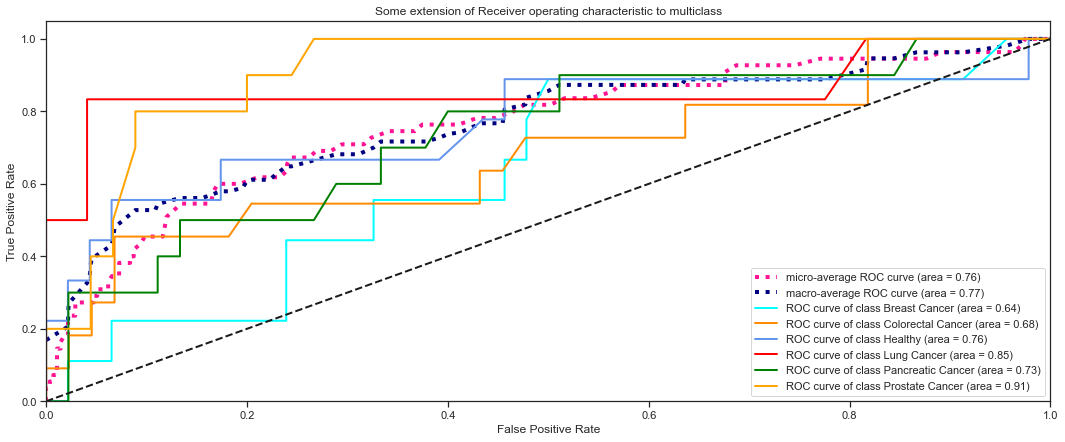

In [126]:

from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

n_classes = 6
X
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    RandomForestClassifier(**params, random_state = 0)
)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

lw = 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(18,7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(cancerTypes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()